# Lab 7 - Cross Validation, Hyperparameter Search

In this lab you'll use *cross validation* to do *hyperparameter search*, a particular form of *model selection*.
* **Cross validation** is a procedure for *estimating* the test-time performance of a given model (the best predictions on held-out test data). Cross validation does not need access to any test data. Instead, it works by holding out some of the training data and using if it were testing data. In this lab we will focus on *K*-fold cross validation, where the training data is divided into *K* equally-sized chunks and each chunk gets a turn "pretending" to be a test set. This will be explained.
* **Model selection** procedures try to select a "best" model from among many alternatives. The best model is usually the one that we can expect to have the best test-time performance. Since cross validation lets us *estimate* the test-time performance, many model selection procedures rely on cross validation as a subroutine.
* **Hyperparameter search** is a particular *model selection* procedure that focuses on selecting one model from a family of related models. Hyperparameter search can therefore be seen as a "model tuning" procedure. For example, we can define all *DecisionTreeClassifiers* with *max_depth* $\in\{1,\ldots,1000\}$ as being a "family" with 1000 possible members to choose from. Hyperparameter search would find a particular setting for *max_depth* that is estimated to have the best possible test-time performance (*not* necessarily the best training performance).  A good hyperparameter search procedure will find good hyperparameters (hyperparameters estimated to have good test-time performance) using very few "attempts", since each attempt requires performing cross validation and this can be computationally demanding.

The goal is to understand what cross validation is, how it is used as a subroutine within a hyperparameter search procedure. You will be asked to try two different hyperparameter search procedures: grid search and random search.

**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.svm               # For SVC
import sklearn.metrics           # For accuracy_score
import sklearn.model_selection   # For GridSearchCV and RandomizedSearchCV
import scipy
import scipy.stats               # For reciprocal distribution
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore sklearn deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)       # Ignore sklearn deprecation warnings

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Understanding the Cross Validation

Exercise 1.1 &ndash;1.2 ask you to load, preprocess the training data (**exercise1_train.csv**) and then split the data to training set and held-out test set (**[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**)

Exercise 1.3 asks you to plot the SVM model with different hyperparameters, this would help you to visualize the grid of hyperparameters.

Exercise 1.4 asks you to perform grid search using **[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**

Exercise 1.5 asks you to perform random hyperparameter search

Exercise 1.6 asks you to evaluate the model selected from exercise 1.4 and 1.5 on the held-out test set


**Run the code cell below** to define some functions for plotting data and model. 

In [2]:
exercise1_extent = (-3, 4, -3, 4)

def plot_decision_function(model):
    """
    Plots the decision function of a model as a red-blue heatmap.
    The region evaluated, along with x and y axis limits, are determined by 'extent'.
    """
    x1min, x1max ,x2min, x2max = exercise1_extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.decision_function(X).reshape(x1.shape)
    plt.imshow(-y, extent=exercise1_extent, origin='lower', vmin=-1, vmax=1, cmap='bwr', alpha=0.5)
    if y.min() < 0 and y.max() > 0:
        plt.contour(x1, x2, y, levels=[0], colors=['k'])  # Decision boundary
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    
def plot_data(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==0].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(exercise1_extent[:2])
    plt.ylim(exercise1_extent[2:])
    plt.gca().set_aspect('equal')    

## Exercise 1.1 Load, re-scale, and plot full data set

Start by loading the data from exercise1_train.csv, then seperate the data and also pre-process the data to the right scale, and plot the data using **plot_data()** function. 

Your plot should look like the figure below.

![image](img/data.png)


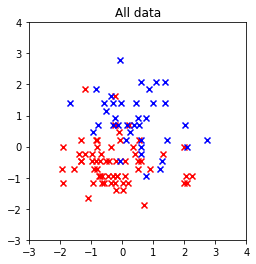

In [4]:
# Your code here. Aim for 6-8 lines.
data = np.loadtxt("exercise1_train.csv", delimiter=",", skiprows=1)
X, y = data[:,:2], data[:, -1]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

plot_data(X, y)
plt.title('All data');


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Overfitting

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a **test set**.

That is, when you train a model to fit your data, it is not guarantted to work well on unseen data. You should evaluate the learned model on some *unseen data*.


## Exericise 1.2 Split full data to training and held-out testing
In this exercise, you should use  **[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)** (Set **random_state = 0**, and **test_size = 0.2**) to split the  data from exercise 1.1 to two groups (**training set** and **held-out test set**), and then plot it in two subplots side-by-side. 



Then, the **training set** will be use to fit a model, and the **held-out test set** will be use to measure the model performance.


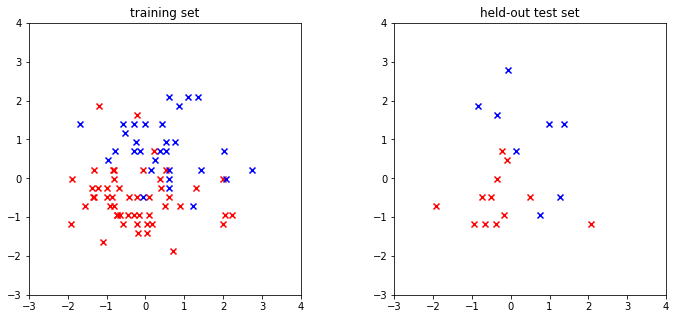

In [8]:
# Your code here. Aim for 6-10 lines.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,
                                                                            test_size=0.2,
                                                                            random_state=0)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("training set")
plot_data(X_train, y_train)

plt.subplot(1,2,2)
plt.title("held-out test set")
plot_data(X_test, y_test)

## Exercise 1.3 Visualize a grid of hyperparameters

In this exercise, you need to train an RBF SVM on the training data using different hyperparameter settings. The specific hyperparameters that you will inspect are *C* (the slack penalty) and the *gamma* (the RBF kernel spread).

To specify a "grid" of values, it is enough to specify the specific "ticks" we'll enumerate along each dimension. For example, if we specified that *C* took values from $\{C_1, C_2\}$ and *gamma* took values from $\{\gamma_1, \gamma_2, \gamma_3\}$ then we have specified the grid of hyperparameter values to try:

$$
\begin{matrix}
(C_1,\gamma_1) & (C_1,\gamma_2) & (C_1,\gamma_3)\\
(C_2,\gamma_1) & (C_2,\gamma_2) & (C_2,\gamma_3)
\end{matrix}
$$

Follow the steps for the code cells below.

**Step 1. Create a 4x4 grid made from 4 distinct *C* values and 4 distinct *gamma* values.**

The values should be "logarithmically spaced", i.e., equally spaced on a logarithmic scale. Use **[numpy.logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html)** to do this. For example, if you choose *C* values to be taken from $[1, 10, 100, 1000]$, these numbers are logarithmically spaced, not uniformly spaced. 

Why do we want logarithmic spacing? Because the *C* and *gamma* hyperparameters are sensiive over *orders of magnitude* and we don't know which order of magnitude is right for training on this data set.

In [9]:
# Your code here. Aim for 2 lines, plus lines for printing the values, if it helps you.
C_grid = np.logspace(0, 3, 4)
gamma_grid = np.logspace(-2, 1, 4)

print(C_grid)
print(gamma_grid)

[   1.   10.  100. 1000.]
[ 0.01  0.1   1.   10.  ]


**Step 2. Print the training accuracy of an RBF SVM for each setting in the grid**

Use for-loops to train an RBF SVM for each combination of (*C*, *gamma*) in your grid, using the variables you already created in the previous code cell. Train the SVMs on the *X_train* and *y_train* data from exercise 1.2.

The output of your code cell should be something like:
```
72.9% training accuracy for C=1.0 gamma=0.01
88.6% training accuracy for C=1.0 gamma=0.10
90.0% training accuracy for C=1.0 gamma=1.00
94.3% training accuracy for C=1.0 gamma=10.00
88.6% training accuracy for C=10.0 gamma=0.01
...
```
Based on your printed training accuracies, would you be able to guess which of these settings of (*C*, *gamma*) might work best on new test data?

In [10]:
# Your code here. Aim for 6-10 lines.
for i in range(4):
    for j in range(4):
        C = C_grid[i]
        gamma = gamma_grid[j]
        svm = sklearn.svm.SVC(C=C, gamma=gamma, kernel='rbf')
        svm.fit(X_train, y_train)
        accuracy = svm.score(X_train, y_train)
        print("%.1f%% training accuracy for C=%.1f gamma=%.2f" % (accuracy*100, C, gamma))

78.8% training accuracy for C=1.0 gamma=0.01
87.5% training accuracy for C=1.0 gamma=0.10
86.2% training accuracy for C=1.0 gamma=1.00
93.8% training accuracy for C=1.0 gamma=10.00
86.2% training accuracy for C=10.0 gamma=0.01
85.0% training accuracy for C=10.0 gamma=0.10
91.2% training accuracy for C=10.0 gamma=1.00
97.5% training accuracy for C=10.0 gamma=10.00
86.2% training accuracy for C=100.0 gamma=0.01
85.0% training accuracy for C=100.0 gamma=0.10
92.5% training accuracy for C=100.0 gamma=1.00
100.0% training accuracy for C=100.0 gamma=10.00
85.0% training accuracy for C=1000.0 gamma=0.01
88.8% training accuracy for C=1000.0 gamma=0.10
95.0% training accuracy for C=1000.0 gamma=1.00
100.0% training accuracy for C=1000.0 gamma=10.00


**Step 3. Plot the decision function for each setting in the grid**

Repeat step 2 but instead of printing accuracies you should instead plot the data (use **plot_data**) and the decision function of the trained SVM model (use **plot_decision_function**). You must create a single figure with 16 subplots arranged in a 4x4 grid, one for each (*C*, *gamma*) hyperparameter setting.

The top-left quadrant (the first 2x2 subplots) should look like the plot below.

![image](img/SVM-CV.png)

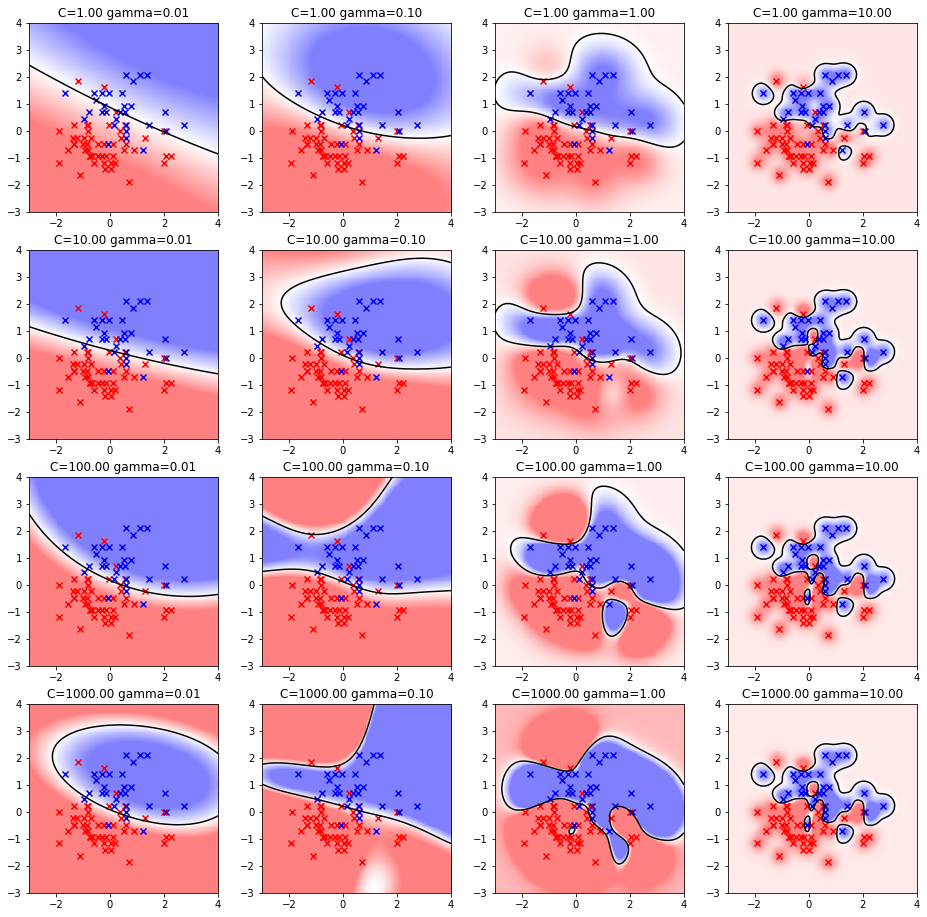

In [11]:
# Your code here. Aim for 9-13 lines.
num_C = len(C_grid)
num_gamma = len(gamma_grid)

plt.figure(figsize=(16, 16))
for i in range(4):
    for j in range(4):
        C = C_grid[i]
        gamma = gamma_grid[j]
        
        svm = sklearn.svm.SVC(C=C, gamma=gamma, kernel='rbf')
        svm.fit(X_train, y_train)

        plt.subplot(num_C, num_gamma, i*num_C + j+1)
        plot_decision_function(svm)
        plot_data(X_train, y_train)
        plt.title('C=%.2f gamma=%.2f' % (C, gamma))

### Question: given the plots above, can you tell which one is going to have the best peformance on the test set you created?



<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### What is the cross validation and why should we use it?

As done in exercise 1.2, we split the data set into the **training set** and the **test set**.

The **training set** is used for fitting a final model (as you did in exercise 1.4), and the **test set** can then be used to evaluate the final model's performance.

However, hyperparameters **are still parameters**, and when we evaluate the performance of a set of hyperparameters on the **test set**, we face the a risk of overfitting our hyperparameters to the test set and therefore over-estimating our test-time performance. Because the parameters can be tweaked until the model performs optimally on the **test set**. This way, knowledge about the **test set** can *leak* into the model and evaluation metrics no longer report on generalization performance.

<div style="border: 1px solid #b00; color:#b00;margin-top: 10px; padding:5px">In other words, suppose you were writing a research paper. If you chose the hyperparameters that directly maximized your test set performance, <em>your paper would surely be <b>rejected</b>!!</em> Why? Because you would almost certainly be over-estimating your test-time performance with such a claim, and so it is a kind of cheating. In fact, at least <a href="https://www.cio.com/article/2935233/baidu-fires-researcher-involved-in-ai-contest-flap.html">one machine learning scientist was <b>fired</b></a> for trying to tune his hyperparameters directly to the test data.</div>

So, we must tune our hyperparameters *without even looking* at the test set. The test set *can only be used to evaluate the final model, after hyperparameter search is complete.* Whatever procedure we use for model selection, that procedure should rely on the training data *only*.

A standard approach is to temporarily "hold out" part of the **training set** as a so-called **validation set**. When we train a model on the remaining training data, it has never seen the validation set before. So, when we evaluate accuracy on the validation set, it is a good approximation of the accuracy we'd expect on our test set. This is called *cross validation*. 


### *K*-fold Cross Validation

If we performed cross validation by choosing a single arbitrary (training, validation) split, the performance on the validation set (our "pretend" test set) would be very sensitive to the particular split, especially if the validation set is small.

*K*-fold cross validation is a procedure for reducing the sensitivity to the particular (training, validation) split. It does this by creating *K* different (training, validation) splits and then averaging the validation performance measured on each one. (Beware that scikit-learn's [desciption of cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) sometimes refers to the *K* individual validation sets as "test sets" so this can be confusing.)

The **K-fold cross validation** procedure is depicted below. Note that the test data is not needed for the cross validation procedure itself, and is only used as an (optional) final performance evaluation, after the optimal hyperparameters have been selected based on the average of *K* validation performances.
<img src="img/k-fold.png" width="550">

(Image source: https://scikit-learn.org/stable/modules/cross_validation.html)

The general procedure is the following:

1. Split the training data into $K$ disjoint 'folds', $(\mathbf{X}, \mathbf{y}) \rightarrow \{(\mathbf{X}_1, \mathbf{y}_1), \ldots, (\mathbf{X}_K, \mathbf{y}_K)\}$, approximately of equal size.
2. For $k = 1,\ldots,K$:
   * Build a training set $(\mathbf{X}_\text{train}, \mathbf{y}_\text{train})$ from all training data *except* fold $k$, *i.e.* combine $K-1$ folds $\left\{(\mathbf{X}_j, \mathbf{y}_j) \mid j \neq k \right\}$.
   * Train a model on $(\mathbf{X}_\text{train}, \mathbf{y}_\text{train})$. This model will have never seen the "validation set" in fold $k$.
   * Compute the "validation score" (e.g. accuracy) on the held-out validation set $(\mathbf{X}_k, \mathbf{y}_k)$. 
3. Return the averge of the $K$ validation scores.

**Note**. For each iteration, the **validate set** and **training set** do not overlap. This means, the validation set remains *unseen* in training process. Thus, it can provide an unbiased estimate of the model's test-time performance.

### Why use k-fold?  
Because it ensures that **<u>every observation from the original dataset has the chance of appearing in training and held-out test set</u>**. This is one among the best approach if we have a limited input data, and it generally results in a less biased model compare to other methods

## Exercise 1.4 Grid hyperparameter search 

In this exercise, you should use the [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to perform a grid hyperparameter search (use the same grid of hyperparameters from *exercise 1.3*) with the use of 3-fold cross validation. 

In particular, you should do the following:
1. Create an **SVC** object to serve as a prototype of the kind of model you wish to train. Make it an RBF SVM.
2. Define the **param_grid** argument to give **GridSearchCV**. This is a dictionary of the form *{ hyperparameter_name: array_of_possible_values }*. For example you could make a variable `param_grid = { 'C': ..., 'gamma': ...}` where `...` are the arrays of values you created early on in Exercise 1.3.
3. Create a **GridSearchCV** object, passing your prototype SVM object and your param_grid as arguments.
  * Set **verbose=1**, this will tell the function to print out more information of the grid search, and helps you to understand.  
  * Use the **cv** parameter to specify 3-fold cross validation
4. Call **fit** on the **GridSearchCV** object to perform the grid search. This will perform 3-fold cross validation for every combination of (*C*, *gamma*) in the grid you specified.
5. Plot the data and the best SVM model from the grid search (use the **GridSearchCV** object's **best_estimator_** attribute)

You may also want to:
* print the validation score (accuracy, by default) of the best-performing hyperparameters by printing the **best_score_** attribute, and
* inspect the best parameters using the **best_params_** attribute.

### Question: 
In this exercise, you are asked to perform the grid hyperparameter search on RBF SVM model, where we want to test 4 different C values and 4 different gamma values, using 3-fold cross validation to evaluate each combination of hyperparameters.
* **How many SVM models will be trained in total**?  
* **What is the main drawback of the grid hyperparameter search**

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best parameters: {'C': 10.0, 'gamma': 0.01}
86.2% accuracy on validation sets (average)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.1s finished


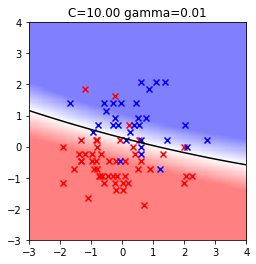

In [12]:
# Your code here. Aim for 6-10 lines.
svm = sklearn.svm.SVC(kernel='rbf')
param_grid = { 'C' : C_grid, 'gamma' : gamma_grid}
gridcv = sklearn.model_selection.GridSearchCV(svm, param_grid, verbose=1, cv=3)
gridcv.fit(X_train, y_train)

plot_decision_function(gridcv.best_estimator_)
plot_data(X_train, y_train)
plt.title('C=%.2f gamma=%.2f' % (gridcv.best_params_['C'], gridcv.best_params_['gamma']));

print("best parameters:", gridcv.best_params_)
print("%.1f%% accuracy on validation sets (average)" % (gridcv.best_score_*100))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exercise 1.5 Random hyperparameter search

Grid Hyperparameter search can be seen as an exhuastive search approach to find the best model congifuration. However, it is not necessar the best, especially in terms of computation efficiency. Thus, random hyperparameter search has been applied widely in various research studies.

**<u>Random hyerperarameter search</u>** does not take a list of grid values, but instead takes distributions that it samples hperparameters from.  

Thus, using a properly distribution for sampling the hyperparameters would be very important. For example, if we sampled from a uniform distribution ([scipy.stats.uniform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html)) in range $[1, 1000]$, there's only a 1\% chance that we'd sample a value between $1$ and $10$. Instead, we can sample from the *reciprocal* distribution ([scipy.stats.reciprocal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.reciprocal.html)) which has logarithmic spacing between samples. A reciprocal distribution over range $[1, 1000]$ has the same chance of drawing a sample in range $[1, 10]$ as it does in range $[10, 100]$ or in range $[100, 1000]$. It is therefore also called a *log uniform* distribution.

**Run the code cell below** to see the differences between sampling values from uniform and reciprocal distribution.

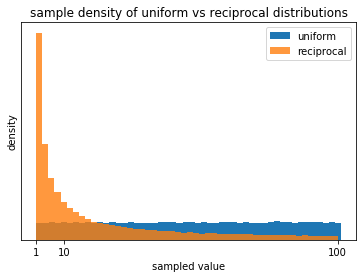

In [10]:
# Create two objects, each representing a different random distribution
reciprocal_distribution = scipy.stats.reciprocal(1, 100)  # Reciprocal distribution in range [0,100]
uniform_distribution = scipy.stats.uniform(1, 100)        # Uniform distribution in range [0,100]

# Draw 100,000 samples from each of the distributions
np.random.seed(0)
reciprocal_samples = reciprocal_distribution.rvs(100000);
uniform_samples = uniform_distribution.rvs(100000);

# Plot the density of samples from each distribution.
plt.hist(uniform_samples, bins=50, label='uniform')
plt.hist(reciprocal_samples, bins=50, label='reciprocal', alpha=0.8);
plt.xticks([1, 10, 100])
plt.yticks([])
plt.xlabel('sampled value')
plt.ylabel('density')
plt.title("sample density of uniform vs reciprocal distributions")
plt.legend();

In the code cell below, use **[sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)** to do a random hyperparameter search.

In particular, you should do the following steps:
1. Define the **param_distribution** argument of **RandomizedSearchCV**. This is similar to the *param_grid* you defined in exercise 1.4 but, instead of specifying grid values, specify a reciprocal distribution to sample each hyperparameter from. 
2. Use **RandomizedSearchCV** to perform random hyperparameter search with 3-fold cross validation. The **RandomizedSearchCV** object will then draw a sample from each of those distributions when evaluating the next hyperparameters.
  * Use argument **random_state=0**, **verbose=1**
  * Set **n_iter=16** in order to match the number of hyperparameters you evaluated with your 4x4 grid search.

3. Print the best hyperparameters you found.
4. Plot the data (use **plot_data()**) and the best SVM model (use **plot_decision_function()**).

Your plot should look something like this:
![image](img/random-search-niter-50.png)

If your decision boundary looks more complex than the anove plot, try increasing the *n_iter* parameter, because 16 random hyperparameter settings may not be enough to find a setting that has a good cross validation score.

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


best parameters: {'C': 4.232824558620119, 'gamma': 0.03047393617736388}
88.6% accuracy on validation sets (average)


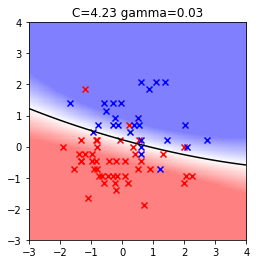

In [11]:
# Your code here. Aim for 8-10 lines.
param_distributions = {
    'C'     : scipy.stats.reciprocal(1.0, 1000.),
    'gamma' : scipy.stats.reciprocal(0.01, 10.),
}
randcv = sklearn.model_selection.RandomizedSearchCV(svm, param_distributions, n_iter=50,
                                                    verbose=1, random_state=0)
randcv.fit(X_train, y_train)

plot_decision_function(randcv.best_estimator_)
plot_data(X_train, y_train)
plt.title('C=%.2f gamma=%.2f' % (randcv.best_params_['C'], randcv.best_params_['gamma']));

print("best parameters:", randcv.best_params_)
print("%.1f%% accuracy on validation sets (average)" % (randcv.best_score_*100))

**Supplementary exercise:** After you have random search working with a *reciprocal* distribution, try changing the distribution to be *uniform* over the same range. Does this help or harm the ability of random search to find a good hyperparameter setting? 

# Exercise 1.6 Take model selected by cross validaton and evaluate its performance on the held-out test data

After hyperparameter search is completed and the final hyperparameters are chosen, you can now do the final evaluation on the model performance using a **held-out test set** if one is available. You explicitly held out a test set ($\mathbf{X}_\text{test}, \mathbf{y}_\text{test}$) in exercise 1.2, so use that data here.

Using your *GridSearchCV* and *RandomSearchCV* objects from Exercises 1.4 and 1.5 respectively, print the training accuracy and test accuracy of the "best estimator" found by each.
* Use the **best_estimator_** attribute to retrive a model that was trained on *all* the training data using the *best* hyperparameters (the hyperparameters with best average validation performance).
* Use **sklearn.metrics.accuracy_score** to compute the accuracy on the training data and on the test data.

Your output should look like:
```
grid search:
  XX.X% train accuracy
  XX.X% test accuracy
random search:
  XX.X% train accuracy
  XX.X% test accuracy
```
*Tip:* Remember that if you want to print a `%` symbol when formatting a string, you must put `%%` in the original string so that Python knows it's not the start of a format specification (like `%d` or `%.2f`).

In [ ]:
# Your code here. Aim for 8-10 lines.
grid_accuracy_train = sklearn.metrics.accuracy_score(y_train, gridcv.best_estimator_.predict(X_train))
grid_accuracy_test  = sklearn.metrics.accuracy_score(y_test,  gridcv.best_estimator_.predict(X_test))
print("grid search:")
print("  %.1f%% train accuracy" % (grid_accuracy_train*100))
print("  %.1f%% test accuracy"  % (grid_accuracy_test*100))

rand_accuracy_train = sklearn.metrics.accuracy_score(y_train, randcv.best_estimator_.predict(X_train))
rand_accuracy_test  = sklearn.metrics.accuracy_score(y_test,  randcv.best_estimator_.predict(X_test))
print("random search:")
print("  %.1f%% train accuracy" % (rand_accuracy_train*100))
print("  %.1f%% test accuracy"  % (rand_accuracy_test*100))